In [1]:
import os
os.chdir('../../..')

In [2]:
os.listdir()

['LICENSE.md',
 'convokit',
 '.DS_Store',
 'requirements.txt',
 'progun_corpus.txt',
 'skipped_users.json',
 'Makefile',
 'website',
 'datasets',
 'tests',
 'README.md',
 'setup.py',
 '.gitignore',
 'ldavis_prepared_8',
 'CONTRIBUTING.md',
 'examples',
 'doc',
 'ldavis_prepared_news_8',
 '.git',
 'antigun_corpus.txt',
 '.idea']

In [3]:
from convokit import Corpus, LanguageModel, download

In [10]:
forum_corpus = Corpus(filename="/Users/calebchiam/Documents/GitHub/cs6742-fork/datasets/gun_debate_forum_corpus")

In [11]:
forum_corpus.print_summary_stats()

Number of Users: 586
Number of Utterances: 64621
Number of Conversations: 449


In [16]:
from collections import defaultdict
leanings = defaultdict(int)
for user in forum_corpus.iter_users():
    if 'lean' in user.meta:
        leanings[user.meta['lean']] += 1 

In [17]:
leanings

defaultdict(int,
            {'Other ': 57,
             'Independent ': 86,
             'Slightly Liberal ': 23,
             'Libertarian ': 32,
             'Very Conservative ': 20,
             'Undisclosed ': 105,
             'Liberal ': 36,
             'Moderate ': 19,
             'Libertarian - Right ': 16,
             'Conservative ': 72,
             'Centrist ': 20,
             'Private ': 6,
             'Progressive ': 27,
             'Slightly Conservative ': 15,
             'Libertarian - Left ': 9,
             'Very Liberal ': 9,
             'Socialist ': 14})

In [18]:
sum(leanings.values())

566

In [19]:
for user in forum_corpus.iter_users():
    if 'lean' in user.meta:
        user.meta['lean'] = user.meta['lean'].strip() # get rid of extra whitespace

In [ ]:
# Liberal, Very Liberal, Progressive
# Libertarian - Right, Conservative, Very Conservative

In [21]:
random_user = next(forum_corpus.iter_users())

In [25]:
antigun_users = []
progun_users = []

for user in forum_corpus.iter_users():
    lean = user.meta.get('lean', None)
    if lean in {'Liberal', 'Very Liberal', 'Progressive'}:
        antigun_users.append(user)
    elif lean in {'Libertarian - Right', 'Conservative', 'Very Conservative'}:
        progun_users.append(user)

In [26]:
len(antigun_users)

72

In [27]:
len(progun_users)

108

## Distribution of utterances

In [28]:
import matplotlib.pyplot as plt

In [43]:
num_utts_antigun_users = [len(list(user.iter_utterances())) for user in antigun_users]
num_utts_progun_users = [len(list(user.iter_utterances())) for user in progun_users]

(array([62.,  5.,  2.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([1.0000e+00, 1.0790e+02, 2.1480e+02, 3.2170e+02, 4.2860e+02,
        5.3550e+02, 6.4240e+02, 7.4930e+02, 8.5620e+02, 9.6310e+02,
        1.0700e+03, 1.1769e+03, 1.2838e+03, 1.3907e+03, 1.4976e+03,
        1.6045e+03, 1.7114e+03, 1.8183e+03, 1.9252e+03, 2.0321e+03,
        2.1390e+03]),
 <a list of 20 Patch objects>)

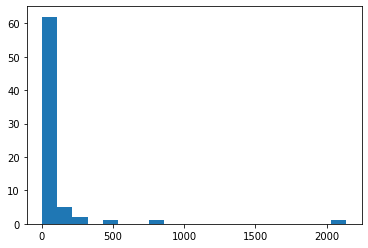

In [44]:
plt.hist(num_utts_antigun_users, bins=20)

Some people say a LOT.

(array([100.,   3.,   2.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([1.00000e+00, 3.91250e+02, 7.81500e+02, 1.17175e+03, 1.56200e+03,
        1.95225e+03, 2.34250e+03, 2.73275e+03, 3.12300e+03, 3.51325e+03,
        3.90350e+03, 4.29375e+03, 4.68400e+03, 5.07425e+03, 5.46450e+03,
        5.85475e+03, 6.24500e+03, 6.63525e+03, 7.02550e+03, 7.41575e+03,
        7.80600e+03]),
 <a list of 20 Patch objects>)

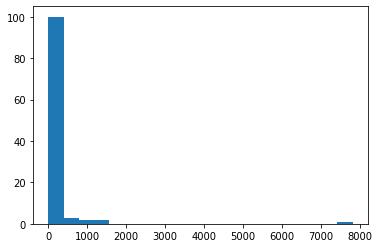

In [46]:
plt.hist(num_utts_progun_users, bins=20) # holy shit that guy at 7500

In [33]:
import numpy as np

In [48]:
print(np.median(num_utts_antigun_users))
print(np.mean(num_utts_antigun_users))

16.5
81.91666666666667


In [49]:
print(np.median(num_utts_progun_users))
print(np.mean(num_utts_progun_users))

14.0
160.74074074074073


To normalize, we take up to 10 utterances per user. If the user has <= 10 utterances, take all of them.

In [51]:
from random import sample

In [55]:
progun_utts = []
for user in progun_users:
    user_utts = list(user.iter_utterances())
    if len(user_utts) <= 10:
        progun_utts.extend(user_utts)
    else:
        progun_utts.extend(sample(user_utts, 10))

In [56]:
antigun_utts = []
for user in antigun_users:
    user_utts = list(user.iter_utterances())
    if len(user_utts) <= 10:
        antigun_utts.extend(user_utts)
    else:
        antigun_utts.extend(sample(user_utts, 10))

In [57]:
len(antigun_utts)

520

In [58]:
len(progun_utts)

772

In [61]:
[utt.text for utt in antigun_utts[:10]]

["There's actually a thread on here showing that gun deaths are rising to record levels. The UK has very few guns in private ownership....and consequently it has VERY low gun crime British police are forced to kill only a tiny fraction of the number of people that trigger happy US police kill. So yes: More guns = more shootings Less guns = Less shootings",
 "No, we'd have a White House that would be functionally normally...not like an episode of The Apprentice. We'd have a competent head of state - not the bombastic fool we have now. ...I've already got my Trump 2020 Keep America Great hat. I can't imagine anybody on the Democratic party who might be running for President who I would vote for over Trump.... How about Elizabeth Warren or Kamala Harris ? ...but I thought you want people to vote, or at least to register.... Correct, I want all citizens to register to vote. I want all registered voters to vote...unless they're going to vote Republican. In which case they should be disquali

In [68]:
[utt.text for utt in progun_utts[:10]]

['I only ever carried strong side on my belt. Except when hiking, in that case I carried a Ruger Service Six in a shoulder holster. This doesn\x92t always work with modern fashion trends especially women\x92s ones. But I feel it is the best. Obviously only you can decide what\x92s best for you',
 'What can the NRA do? The oppose all the laws being used to arrest these people I am sure, but in the end it’s still up to you to follow',
 'Well that’s what I though about the AZ cop who shot the guy crawling in the hotel carpet, jury acquittal there',
 'You’re actually incorrect about one thing, the army issued the .38 long colt, which was less powerful then the .38 special. In fact the .38 special is a magnum of the .38 long colt and was made to fix that issue',
 "I feel Minnesota has the best background check law, you can sell someone a gun without a background check, but if you do and the person you sold it to was unable to legally possess a gun and commits a crime within a certain time p

In [75]:
def clean_text(txt):
    return txt.replace("\n", " ").replace('\x92', "'")

In [71]:
progun_text = ''
for utt in progun_utts:
    if utt.text.endswith('.'):
        progun_text += clean_text(utt.text) + ' '
    else:
        progun_text += clean_text(utt.text) + '. '

In [76]:
antigun_text = ''
for utt in antigun_utts:
    if utt.text.endswith('.'):
        antigun_text += clean_text(utt.text) + ' '
    else:
        antigun_text += clean_text(utt.text) + '. '

In [77]:
len(progun_text)

238681

In [78]:
len(antigun_text)

172369

In [79]:
from nltk import sent_tokenize

In [87]:
with open('progun_forum_corpus.txt', 'w') as f:
    for sentence in sent_tokenize(progun_text):
        if len(sentence) > 5:
            f.write(sentence)
            f.write("\n")

In [88]:
with open('antigun_forum_corpus.txt', 'w') as f:
    for sentence in sent_tokenize(antigun_text):
        if len(sentence) > 5:
            f.write(sentence)
            f.write("\n")

## Training step

In [103]:
lm = LanguageModel(SRILM_path='/Users/calebchiam/Documents/GitHub/cs6742-fork/convokit/SRILM/srilm-1.7.3',
                  working_dir='/Users/calebchiam/Documents/GitHub/cs6742-fork/convokit/SRILM/dump/',
                  lm_output_path='progun_forum.lm',
                  lm_type='laplace',
                  count_output_path='progun_forum_counts.txt',
                  order=2,
                  verbose=True)

In [104]:
lm.train('progun_forum_corpus.txt')

In [105]:
lm.str_perplexity("I love guns.")

file /Users/calebchiam/Documents/GitHub/cs6742-fork/convokit/SRILM/dump/temp/280594959603171588.txt: 1 sentences, 3 words, 0 OOVs
0 zeroprobs, logprob= -10.97168 ppl= 553.2469 ppl1= 4541.772


553.2469

In [106]:
lm.str_perplexity("I hate guns.")

file /Users/calebchiam/Documents/GitHub/cs6742-fork/convokit/SRILM/dump/temp/643164199682958812.txt: 1 sentences, 3 words, 0 OOVs
0 zeroprobs, logprob= -11.1783 ppl= 623.125 ppl1= 5322.311


623.125

In [107]:
lm.str_perplexity("We have a right to arm ourselves.")

file /Users/calebchiam/Documents/GitHub/cs6742-fork/convokit/SRILM/dump/temp/8219121977068413720.txt: 1 sentences, 7 words, 1 OOVs
0 zeroprobs, logprob= -17.98651 ppl= 371.1088 ppl1= 994.836


371.1088

In [108]:
lm.str_perplexity("We do not have a right to arm ourselves.")

file /Users/calebchiam/Documents/GitHub/cs6742-fork/convokit/SRILM/dump/temp/8424412835006428244.txt: 1 sentences, 9 words, 1 OOVs
0 zeroprobs, logprob= -24.04541 ppl= 469.5826 ppl1= 1013.155


469.5826

In [112]:
lm2 = LanguageModel(SRILM_path='/Users/calebchiam/Documents/GitHub/cs6742-fork/convokit/SRILM/srilm-1.7.3',
                  working_dir='/Users/calebchiam/Documents/GitHub/cs6742-fork/convokit/SRILM/dump/',
                  lm_output_path='antigun_forum.lm',
                  lm_type='laplace',
                  count_output_path='antigun_forum_counts.txt',
                  order=2,
                  verbose=False)

In [113]:
lm2.train('antigun_forum_corpus.txt')

In [119]:
lm2.str_perplexity("I love guns.")

492.8375

In [120]:
lm2.str_perplexity("I hate guns.")

490.4409

In [121]:
lm2.str_perplexity("We have a right to arm ourselves.")

377.7095

In [122]:
lm2.str_perplexity("We do not have a right to arm ourselves.")

410.2935

In [254]:
import json
with open("skipped_users.json", 'w') as f:
    json.dump({"users": list(skipped_users)}, f)